In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from datetime import datetime
import os

Instructions for updating:
non-resource variables are not supported in the long term


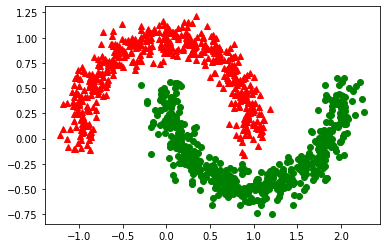

In [2]:
m = 1000
X_moons, y_moons = make_moons(m, noise=0.1, random_state=42)

plt.plot(X_moons[y_moons == 1, 0], X_moons[y_moons == 1, 1], 'go')
plt.plot(X_moons[y_moons == 0, 0], X_moons[y_moons == 0, 1], 'r^')
plt.show()

In [3]:
X_moons_with_bias = np.c_[np.ones((m, 1)), X_moons]
y_moons_column_vector = y_moons.reshape(-1, 1)

In [4]:
test_ratio = 0.2
test_size = int(m * test_ratio)
X_train = X_moons_with_bias[:-test_size]
X_test = X_moons_with_bias[-test_size:]
y_train = y_moons_column_vector[:-test_size]
y_test = y_moons_column_vector[-test_size:]

X_train_enhanced = np.c_[X_train,
                         np.square(X_train[:, 1]),
                         np.square(X_train[:, 2]),
                         X_train[:, 1] ** 3,
                         X_train[:, 2] ** 3]
X_test_enhanced = np.c_[X_test,
                        np.square(X_test[:, 1]),
                        np.square(X_test[:, 2]),
                        X_test[:, 1] ** 3,
                        X_test[:, 2] ** 3]

In [5]:
def random_batch(X_train, y_train, batch_size):
    rnd_indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return X_batch, y_batch

In [6]:
def logistic_regression(X, y, initializer=None, seed=42, learning_rate=0.01):
    n_inputs_including_bias = int(X.get_shape()[1])
    
    with tf.name_scope("logistic_regression"):
        with tf.name_scope("model"):
            if initializer is None:
                initializer = tf.random_uniform([n_inputs_including_bias, 1], -1.0, 1.0, seed=seed)
            theta = tf.Variable(initializer, name="theta")
            logits = tf.matmul(X, theta, name="logits")
            y_proba = tf.sigmoid(logits)
            
        with tf.name_scope("train"):
            loss = tf.losses.log_loss(y, y_proba, scope="loss")
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
            training_op = optimizer.minimize(loss)
            loss_summary = tf.summary.scalar('log_loss', loss)
            
        with tf.name_scope("init"):
            init = tf.global_variables_initializer()
            
        with tf.name_scope("save"):
            saver = tf.train.Saver()
            
    return y_proba, loss, training_op, loss_summary, init, saver

In [7]:
n_inputs = 6 #a1 a a6 (a0 é bias)

X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(X, y)

file_writer = tf.compat.v1.summary.FileWriter('/logs', tf.get_default_graph())

In [8]:
n_epochs = 10001
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

checkpoint_path = "/tmp/my_logreg_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./my_logreg_model"

with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)

    for epoch in range(start_epoch, n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train_enhanced, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            
        loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test_enhanced, y: y_test})
        file_writer.add_summary(summary_str, epoch)
        
        if epoch % 500 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))

    saver.save(sess, final_model_path)
    y_proba_val = y_proba.eval(feed_dict={X: X_test_enhanced, y: y_test})
    os.remove(checkpoint_epoch_path)

Epoch: 0 	Loss: 0.8106414
Epoch: 500 	Loss: 0.17480464
Epoch: 1000 	Loss: 0.12639582
Epoch: 1500 	Loss: 0.10199581
Epoch: 2000 	Loss: 0.08695709
Epoch: 2500 	Loss: 0.07675868
Epoch: 3000 	Loss: 0.069307975
Epoch: 3500 	Loss: 0.063617036
Epoch: 4000 	Loss: 0.059186872
Epoch: 4500 	Loss: 0.05551185
Epoch: 5000 	Loss: 0.052455746
Epoch: 5500 	Loss: 0.04993515
Epoch: 6000 	Loss: 0.047748003
Epoch: 6500 	Loss: 0.045853842
Epoch: 7000 	Loss: 0.044167668
Epoch: 7500 	Loss: 0.04268742
Epoch: 8000 	Loss: 0.041349497
Epoch: 8500 	Loss: 0.040138528
Epoch: 9000 	Loss: 0.03908777
Epoch: 9500 	Loss: 0.038108397
Epoch: 10000 	Loss: 0.037199784


In [11]:
y_pred = (y_proba_val >= 0.5)
precision_score(y_test, y_pred)

0.9797979797979798

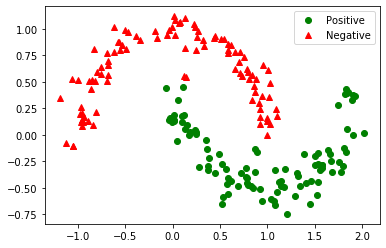

In [12]:
y_pred_idx = y_pred.reshape(-1) # a 1D array rather than a column vector
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="Positive")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="Negative")
plt.legend()
plt.show()